<a href="https://colab.research.google.com/github/PGM-Lab/2023-RateFunction/blob/main/Notebooks/Figure1_and_Figure6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get update
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:14 http://archive.ubuntu.com/ubuntu fo

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
from tqdm import tqdm

from google.colab import files
import pickle

In [3]:

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
from matplotlib.pyplot import figure

In [4]:
def non_latex_format():
  mpl.rcParams.update(mpl.rcParamsDefault)

  matplotlib.rcParams['pdf.fonttype'] = 42
  matplotlib.rcParams['ps.fonttype'] = 42
  plt.rcParams['figure.figsize'] = (16, 9)
  fontsize = 26
  matplotlib.rcParams.update({'font.size': fontsize})

def latex_format():
  plt.rcParams.update({
      'font.size': 10,
      'text.usetex': True,
      'text.latex.preamble': r'\usepackage{amsfonts}\usepackage{bm}'
  })
  mpl.rc('font',family='Times New Roman')
  matplotlib.rcParams['pdf.fonttype'] = 42
  matplotlib.rcParams['ps.fonttype'] = 42
  plt.rcParams['figure.figsize'] = (16, 9)
  fontsize = 30
  matplotlib.rcParams.update({'font.size': fontsize})


In [5]:
non_latex_format()

In [6]:
criterion = nn.CrossEntropyLoss() # supervised classification loss
criterion_nonreduced = nn.CrossEntropyLoss(reduce=False) # supervised classification loss

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [7]:
!nvidia-smi

Tue Sep  5 09:53:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Set-Up

In [8]:
# LENET parameters
RANDOM_SEED = 2147483647
LEARNING_RATE = 0.01 #0.0001 for MLP
SUBSET_SIZE = 50000
TEST_SUBSET_SIZE = 10000
N_ITERS = 30000
BATCH_SIZE = 200
BATCH_SIZE_TEST = 1000


IMG_SIZE = 32
N_CLASSES = 10

#Set to zero to disconnect L2.
weight_decay = 0.01

setting_name=f"rs_{RANDOM_SEED}_inception_lr_{LEARNING_RATE}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{BATCH_SIZE}_wd_{weight_decay}"
setting_name

'rs_2147483647_inception_lr_0.01_trainsize_50000_testsize_10000_niters_30000_batchsize_200_wd_0.01'

In [9]:
use_cifar = True
use_mnist = False

# Data

In [10]:
# setup devices
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.manual_seed(RANDOM_SEED)
else:
    device = torch.device("cpu")

transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                 torchvision.transforms.ToTensor()])

transforms_crop = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop((32, 32),  scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                                 torchvision.transforms.ToTensor()])

In [11]:
!nvidia-smi

Tue Sep  5 09:53:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:

train_dataset = datasets.CIFAR10(root='cifar_data',
                                train=True,
                                transform=transforms,
                                download=True)

train_dataset_crop = datasets.CIFAR10(root='cifar_data',
                                train=True,
                                transform=transforms_crop,
                                download=True)

test_dataset = datasets.CIFAR10(root='cifar_data',
                                train=False,
                                transform=transforms)

test_dataset_crop = datasets.CIFAR10(root='cifar_data',
                                train=False,
                                transform=transforms_crop)


Files already downloaded and verified
Files already downloaded and verified


In [13]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

class CIFAR10Corrupted(CIFAR10):
    def __init__(self, num_classes=10, **kwargs):
        super().__init__(**kwargs)
        self.n_classes = num_classes
        self.corrupt_labels()

    def corrupt_labels(self):
        labels = np.array(self.targets)
        np.random.seed(42)
        rnd_labels = np.random.choice(self.n_classes, size = len(self.targets))
        self.targets = rnd_labels.flatten()

def get_cifar_dataloaders_corrupted():

    trainset = CIFAR10Corrupted(root='cifar_data', train=True, download=True, transform=transforms)
    return trainset


In [14]:
train_dataset_shuffled = get_cifar_dataloaders_corrupted()

Files already downloaded and verified


In [15]:
train_dataset = torch.utils.data.Subset(train_dataset, list(range(0, SUBSET_SIZE)))
train_dataset_crop = torch.utils.data.Subset(train_dataset_crop, list(range(0, SUBSET_SIZE)))
train_dataset_shuffled = torch.utils.data.Subset(train_dataset_shuffled, list(range(0, SUBSET_SIZE)))

test_dataset = torch.utils.data.Subset(test_dataset, list(range(0, TEST_SUBSET_SIZE)))

In [16]:

test_loader_batch = torch.utils.data.DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE_TEST,
                          shuffle=False)

test_loader_crop_batch = torch.utils.data.DataLoader(dataset=test_dataset_crop,
                          batch_size=BATCH_SIZE_TEST,
                          shuffle=False)

# Model

In [17]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class InceptionModule(nn.Module):

    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )

        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()

        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class InceptionNet(nn.Module):
    def __init__(self, num_classes, input_channels):
        super().__init__()

        self.conv1 = ConvModule(in_channels =input_channels,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [18]:
from torchvision.models import resnet50

def createmodel():
  return InceptionNet(10, train_dataset[0][0].shape[0])

# Code

In [19]:
def get_log_p(device, model, loader):
    cce = nn.CrossEntropyLoss(reduction = "none") # supervised classification loss
    model.eval()
    aux = []
    with torch.no_grad():
      for data, targets in loader:
          data = data.to(device)
          targets = targets.to(device)
          logits = model(data)
          probs = F.softmax(logits, dim=1)
          log_p = -cce(logits, targets) # supervised loss
          aux.append(log_p)
    return torch.cat(aux)

In [20]:
#Binary Search for lambdas
def rate_function_BS(model, s_value, loader = test_loader_batch):
  if (s_value<0):
    min_lamb=torch.tensor(-10000).to(device)
    max_lamb=torch.tensor(0).to(device)
  else:
    min_lamb=torch.tensor(0).to(device)
    max_lamb=torch.tensor(10000).to(device)

  s_value=torch.tensor(s_value).to(device)
  log_p = get_log_p(device, model, loader)
  return aux_rate_function_TernarySearch(log_p, s_value, min_lamb, max_lamb, 0.001)

def eval_log_p(log_p, lamb, s_value):
  jensen_val=(torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - lamb *torch.mean(log_p))
  return lamb*s_value - jensen_val

def aux_rate_function_BinarySearch(log_p, s_value, low, high, epsilon):

  while (high - low) > epsilon:
      mid = (low + high) / 2
      print(mid)
      print(eval_log_p(log_p, low, s_value))
      print(eval_log_p(log_p, mid, s_value))
      print(eval_log_p(log_p, high, s_value))
      print("--")
      if eval_log_p(log_p, mid, s_value) < eval_log_p(log_p, high, s_value):
          low = mid
      else:
          high = mid

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


def aux_rate_function_TernarySearch(log_p, s_value, low, high, epsilon):

  while (high - low) > epsilon:
    mid1 = low + (high - low) / 3
    mid2 = high - (high - low) / 3

    if eval_log_p(log_p, mid1, s_value) < eval_log_p(log_p, mid2, s_value):
        low = mid1
    else:
        high = mid2

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]

import math
def aux_rate_function_golden_section_search(log_p, s_value, a, b, epsilon):
    """
    Maximizes a univariate function using the golden section search algorithm.

    Parameters:
        f (function): The function to minimize.
        a (float): The left endpoint of the initial search interval.
        b (float): The right endpoint of the initial search interval.
        tol (float): The error tolerance value.

    Returns:
        float: The x-value that minimizes the function f.
    """
    # Define the golden ratio
    golden_ratio = (torch.sqrt(torch.tensor(5).to(device)) - 1) / 2

    # Define the initial points
    c = b - golden_ratio * (b - a)
    d = a + golden_ratio * (b - a)

    # Loop until the interval is small enough
    while abs(c - d) > epsilon:
        # Compute the function values at the new points
        fc = eval_log_p(log_p, c, s_value)
        fd = eval_log_p(log_p, d, s_value)

        # Update the interval based on the function values
        if fc > fd:
            b = d
            d = c
            c = b - golden_ratio * (b - a)
        else:
            a = c
            c = d
            d = a + golden_ratio * (b - a)

    # Return the midpoint of the final interval
    mid = (a + b) / 2
    return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


In [21]:
def eval_jensen(model, lambdas):
  log_p = get_log_p(device, model, test_loader_batch)
  return np.array(
      [
          (torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - torch.mean(lamb * log_p)).detach().cpu().numpy() for lamb in lambdas
       ])

def inverse_rate_function(model, lambdas, rate_vals):
  jensen_vals = eval_jensen(model, lambdas)

  return np.array([ np.min((jensen_vals + rate)/lambdas) for rate in rate_vals])


In [22]:
def eval(device, model, loader, criterion):
    correct = 0
    total = 0
    losses = []
    model.eval()
    with torch.no_grad():
        for data, targets in loader:
            total += targets.size(0)
            data = data.to(device)
            targets = targets.to(device)
            logits = model(data)
            probs = F.softmax(logits, dim=1)
            predicted = torch.argmax(probs, 1)
            correct += (predicted == targets).sum().detach().cpu().numpy()

            loss = criterion(logits, targets) # supervised loss
            losses.append(loss.detach().cpu().numpy())

    return correct, total, np.mean(losses), np.var(losses)

In [23]:
SKIP=False
lambdas = np.arange(-10, 10, 0.01)

def train(model, train_loader, weight_decay=0):

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, verbose = False)
    data_iter = iter(train_loader)
    iters_per_epoch = len(data_iter)
    aux_loss = 1
    tq = tqdm(range(N_ITERS))
    for it in tq:

            model.train()

            try:
                inputs, target = next(data_iter)
            except StopIteration:
                # StopIteration is thrown if dataset ends
                # reinitialize data loader
                data_iter = iter(train_loader)
                inputs, target = next(data_iter)


            inputs = inputs.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            logits = model(inputs) # forward pass

            loss = criterion(logits, target) # supervised loss
            aux_loss += loss.detach().cpu().numpy()

            tq.set_postfix({'Train cce': loss.detach().cpu().numpy()})


            if weight_decay>0:
              # Add L2 regularization to the loss
              l2_reg = torch.tensor(0.).to(device)
              for param in model.parameters():
                  l2_reg += torch.norm(param)
              loss += weight_decay * l2_reg

            loss.backward() # computes gradients
            optimizer.step()

            if it % iters_per_epoch == 0:
              scheduler.step()
              if aux_loss/iters_per_epoch < 0.005:
                print("Early-stopping")
                break
              aux_loss = 0



    return model

# Training

In [24]:
models = [createmodel().to(device) for _ in range(5)]
loader = []

g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
loader.append(torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          generator=g_cuda,
                          shuffle=True))

g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
loader.append(torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          generator=g_cuda,
                          shuffle=True))

g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
loader.append(torch.utils.data.DataLoader(dataset=train_dataset_crop,
                          batch_size=BATCH_SIZE,
                          generator=g_cuda,
                          shuffle=True))

g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
loader.append(torch.utils.data.DataLoader(dataset=train_dataset_crop,
                          batch_size=BATCH_SIZE,
                          generator=g_cuda,
                          shuffle=True))

g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
loader.append(torch.utils.data.DataLoader(dataset=train_dataset_shuffled,
                          batch_size=BATCH_SIZE,
                          generator=g_cuda,
                          shuffle=True))


weight_decays = [0.0, weight_decay, 0.0, weight_decay, 0.0]
labels = ["Standard", "L2", "Crop", "L2-Crop", "Random"]


In [25]:
jet = plt.cm.get_cmap('Dark2')
colors = {
    "Standard": jet(0),
    "L2": jet(1),
    "Crop": jet(2),
    "L2-Crop": jet(3),
    "Random": jet(4)
}


markers = {
    "Standard": "X",
    "L2": "s",
    "Crop": "^",
    "L2-Crop": "<",
    "Random": "*"
}



In [26]:
results = []
for i in range(len(models)):
  results.append(train(models[i], loader[i], weight_decay=weight_decays[i]))
  with open(f'sgd_images/{setting_name}_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/30000 [00:05<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
eval(device, createmodel().to(device), test_loader_batch, criterion)

(1000, 10000, 2.302629, 1.3532276e-07)

In [ ]:
for i in range(len(models)):
  print(labels[i])
  print("Train", eval(device, models[i],  loader[i], criterion))
  print("Test", eval(device, models[i],  test_loader_batch, criterion))

Inception
Train (49999, 50000, 0.0023565707, 4.6568243e-07)
Test (8436, 10000, 0.6557811, 0.0035014781)
Inception-L2
Train (50000, 50000, 0.0022527338, 1.2671833e-07)
Test (8660, 10000, 0.49843162, 0.0018191319)
Inception-Crop
Train (49971, 50000, 0.0042447145, 7.892405e-06)
Test (8689, 10000, 0.5871979, 0.0023411235)
Inception-L2-Crop
Train (49993, 50000, 0.004091027, 3.2923244e-06)
Test (8845, 10000, 0.4202022, 0.0020244843)
Inception-Random
Train (50000, 50000, 0.01237456, 1.2919899e-06)
Test (1013, 10000, 5.5234256, 0.012642367)


In [26]:
BATCH_LOSS=0
TRAIN_LOSS=1
TEST_LOSS=2
VARIANCE=3
MODELS=4
train_loss = [BATCH_LOSS, BATCH_LOSS, BATCH_LOSS, BATCH_LOSS, BATCH_LOSS]

# Figure 4: Jensen-Gap Functions Evolution

In [27]:
with open(f"sgd_images/{setting_name}_results.pickle", "rb") as handle:
  results = pickle.load(handle)

In [28]:
lambdas = np.arange(0, 0.5, 0.01)
jensens = []

for i in range(len(models)):
  jensens.append(eval_jensen(results[i].to(device), lambdas))


new_model = createmodel().to(device)
jensens.append(eval_jensen(new_model.to(device), lambdas))

In [ ]:

for i in range(len(models)):
  print()
  l2_reg = 0
  for param in results[i].parameters():
    l2_reg += torch.norm(param)
  print(labels[i], ": ", l2_reg.detach().cpu().numpy())

for param in new_model.parameters():
  l2_reg += torch.norm(param)
print("Initial model: ", l2_reg.detach().cpu().numpy())



Standard :  304.169

L2 :  200.12051

Crop :  309.86862

L2-Crop :  130.98254

Random :  311.16617
Initial model:  593.6332


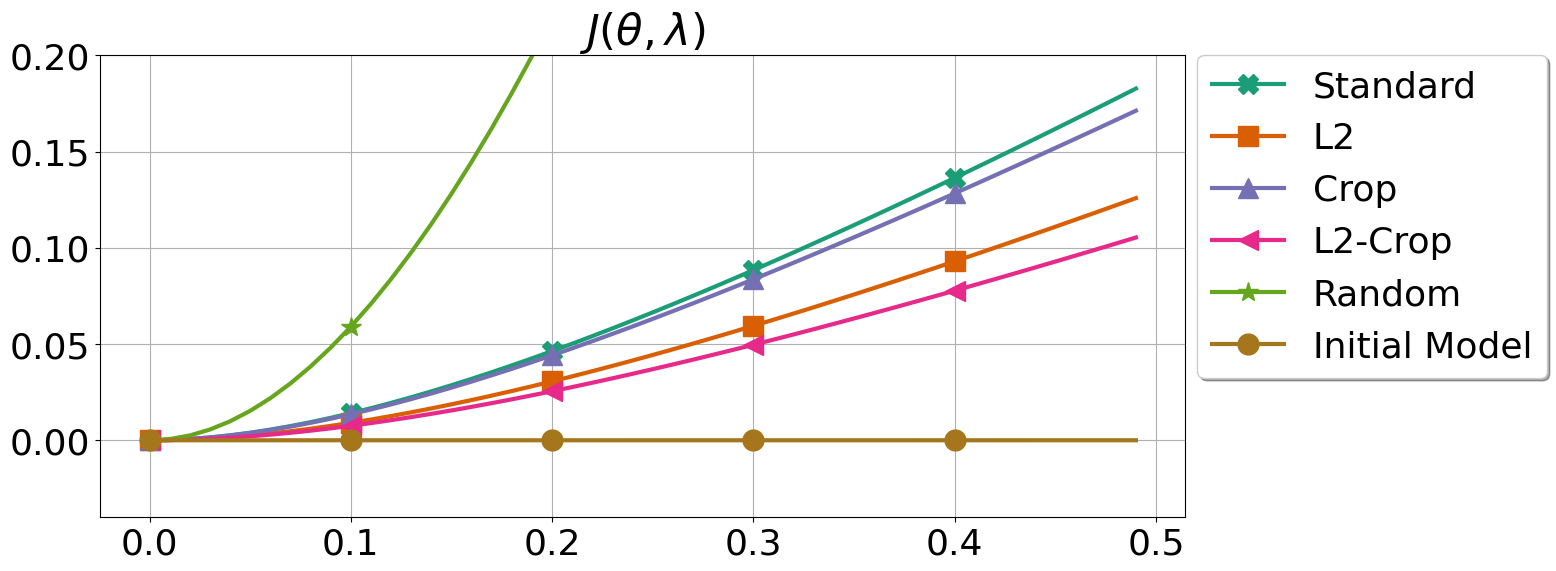

In [ ]:
plt.rcParams['figure.figsize'] = (14, 6)
for i in range(len(jensens)-1):
  plt.plot(lambdas, jensens[i], label=labels[i] ,linewidth=3, color = colors[labels[i]], marker = markers[labels[i]],  markersize=15, markevery=10)


plt.plot(lambdas, jensens[-1], label="Initial Model" ,linewidth=3, color = jet(6), marker = "o",  markersize=15, markevery=10)


plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.04),
          ncol=1, fancybox=True, shadow=True)
#plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
plt.ylim(-0.04,0.2)
plt.grid()
plt.title(r"$J(\theta,\lambda)$")

plt.savefig("sgd_images/jensen_intro.pdf", format = "pdf",bbox_inches='tight')
plt.show()

In [ ]:
latex_format()

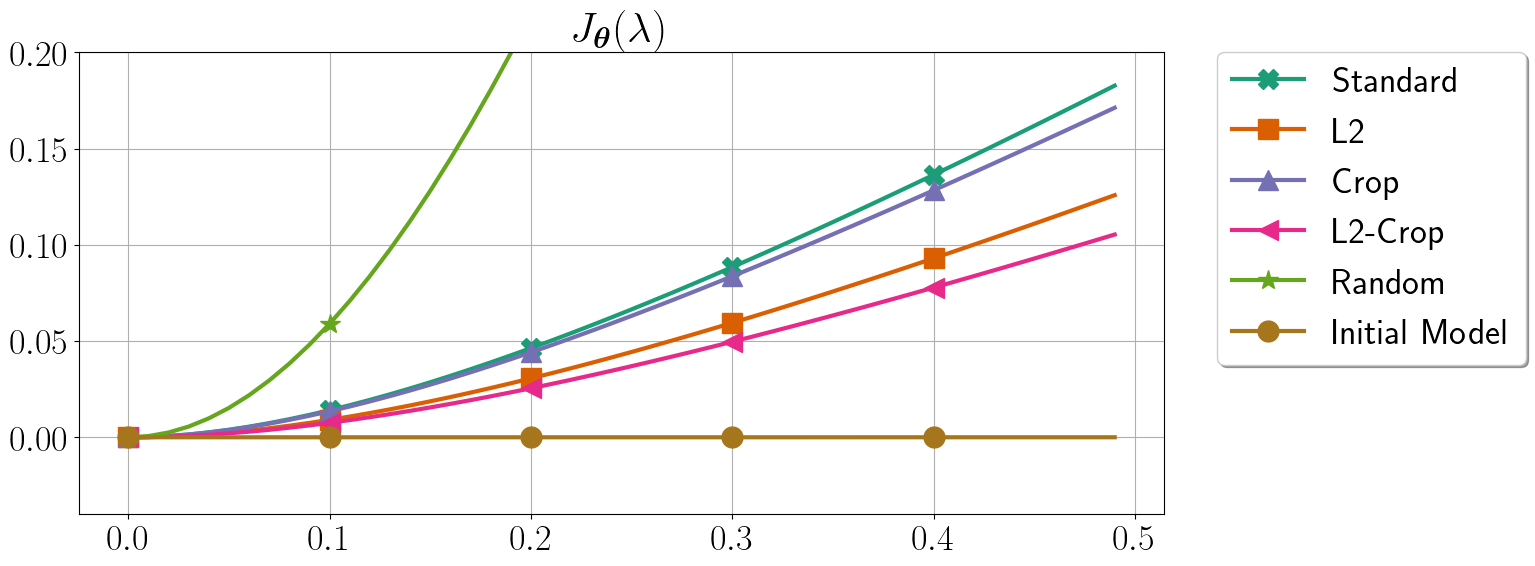

In [ ]:
plt.rcParams['figure.figsize'] = (14, 6)
for i in range(len(jensens)-1):
  plt.plot(lambdas, jensens[i], label=labels[i] ,linewidth=3, color = colors[labels[i]], marker = markers[labels[i]],  markersize=15, markevery=10)


plt.plot(lambdas, jensens[-1], label="Initial Model" ,linewidth=3, color = jet(6), marker = "o",  markersize=15, markevery=10)


plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.04),
          ncol=1, fancybox=True, shadow=True)
#plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
plt.ylim(-0.04,0.2)
plt.grid()
plt.title(r"$J_{\bm{\theta}}(\lambda)$")

plt.savefig("sgd_images/jensen_intro.pdf", format = "pdf",bbox_inches='tight')
plt.show()

In [ ]:
s_values = np.arange(0, 0.5, 0.01)
Is = []

for i in range(len(models)):
  Is.append(np.array([rate_function_BS(results[i].to(device), s)[0] for s in s_values]))


new_model = createmodel().to(device)
Is.append(np.array([rate_function_BS(new_model, s)[0] for s in s_values]))

In [ ]:
non_latex_format()

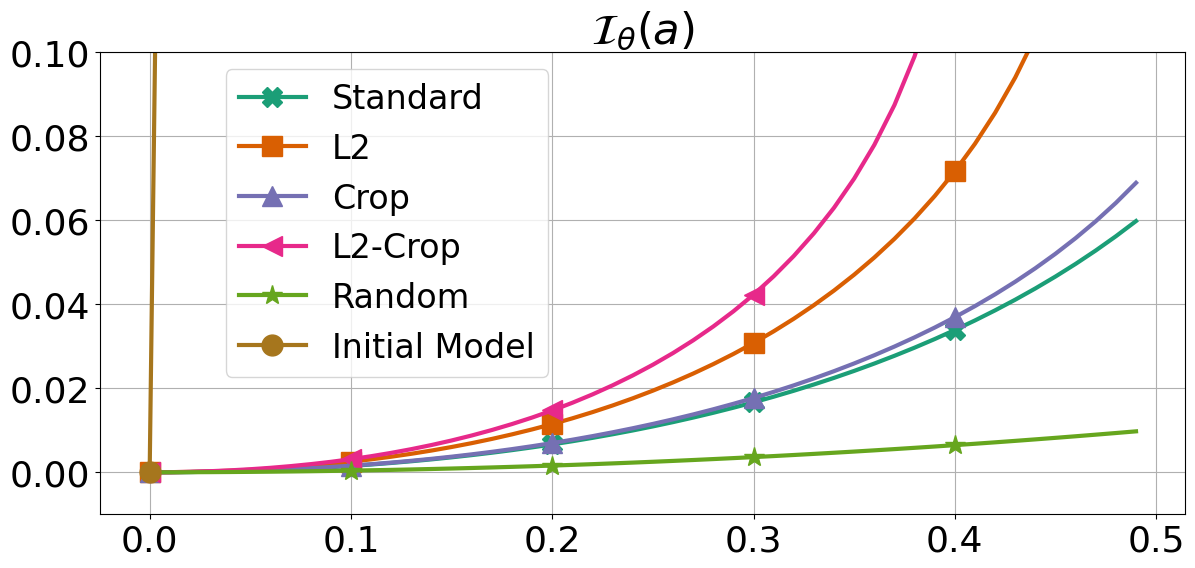

In [ ]:
plt.rcParams['figure.figsize'] = (14, 6)
for i in range(len(Is)-1):
  plt.plot(s_values, Is[i], label=labels[i] ,linewidth=3, color = colors[labels[i]], marker = markers[labels[i]],  markersize=15, markevery=10)


plt.plot(s_values, Is[-1], label="Initial Model" ,linewidth=3, color = jet(6), marker = "o",  markersize=15, markevery=10)


#plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.04), ncol=1, fancybox=True, shadow=True)
#plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
plt.legend(fontsize=24, bbox_to_anchor=(0.1, 1))
plt.ylim(-0.01,0.1)
plt.grid()
plt.title(r"${\cal I}_{\theta}(a)$")

plt.savefig("sgd_images/rate_intro.pdf", format = "pdf",bbox_inches='tight')
plt.show()

In [ ]:
latex_format()

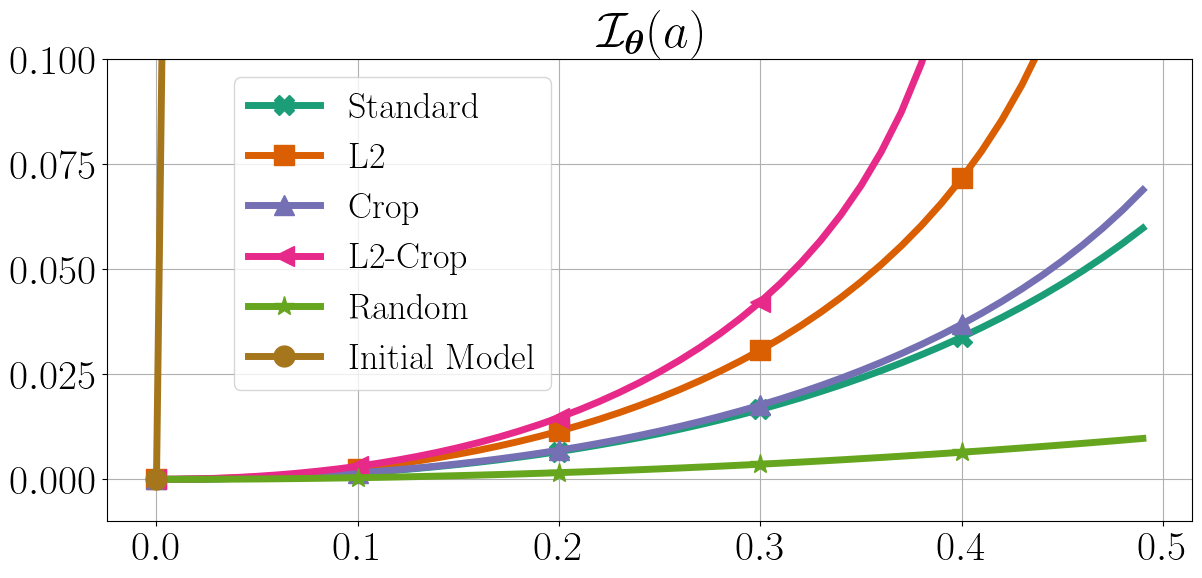

In [ ]:
plt.rcParams['figure.figsize'] = (14, 6)
for i in range(len(Is)-1):
  plt.plot(s_values, Is[i], label=labels[i] ,linewidth=5, color = colors[labels[i]], marker = markers[labels[i]],  markersize=15, markevery=10)


plt.plot(s_values, Is[-1], label="Initial Model" ,linewidth=5, color = jet(6), marker = "o",  markersize=15, markevery=10)


#plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.04), ncol=1, fancybox=True, shadow=True)
#plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
plt.legend(fontsize=26, bbox_to_anchor=(0.1, 1))
plt.ylim(-0.01,0.1)
plt.grid()
plt.title(r"${\cal I}_{\bm{\theta}}(a)$")

plt.savefig("sgd_images/rate_intro_latex.pdf", format = "pdf",bbox_inches='tight')
plt.show()

# Deviation plots


In [37]:
n = 50

In [38]:
g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
loader = torch.utils.data.DataLoader(dataset=test_dataset,
                          batch_size=n,
                          generator=g_cuda,
                          shuffle=True)

loader_crop = torch.utils.data.DataLoader(dataset=test_dataset_crop,
                          batch_size=n,
                          generator=g_cuda,
                          shuffle=True)



In [39]:
def eval(device, model, loader, criterion, epochs = 1):
    losses = []
    model.eval()
    with torch.no_grad():
        for _ in range(epochs):
          for data, targets in loader:
              data = data.to(device)
              targets = targets.to(device)
              logits = model(data)

              loss = criterion(logits, targets) # supervised loss
              losses.append(loss.detach().cpu().numpy())

    return np.array(losses)

In [40]:
cmap = matplotlib.cm.get_cmap('Dark2')

In [41]:
indices = [0, 3, 4]
models = [
    results[0],
    results[3],
    createmodel()
]

train_losses = []
test_losses = []
train_losses_crop = []
test_losses_crop = []

for m in models:
  train_losses.append(eval(device, m.to(device), loader, criterion, 4))
  test_losses.append(np.mean(eval(device, m.to(device), loader, criterion)))
  train_losses_crop.append(eval(device, m.to(device), loader_crop, criterion, 4))
  test_losses_crop.append(np.mean(eval(device, m.to(device), loader_crop, criterion)))

In [42]:
s_values = [(test_losses[i] - plt.hist(np.array(train_losses)[i], bins = 50, density = True)[1])[::-1] for i in range(len(models))]
s_values_crop = [(test_losses_crop[i] - plt.hist(np.array(train_losses_crop)[i], bins = 50, density = True)[1])[::-1] for i in range(len(models))]
plt.clf()

In [43]:
Is = []
#Is_crop = []

tq = tqdm(range(len(models)))
for i in tq:
  Is.append(np.array([rate_function_BS(models[i].to(device), s)[0] for s in s_values[i]]))
  #Is_crop.append(np.array([rate_function_BS_aug(models[i].to(device), s, test_losses[i], loader_crop)[0] for s in s_values_crop[i]]))



100%|██████████| 3/3 [06:01<00:00, 120.36s/it]


In [44]:
non_latex_format()

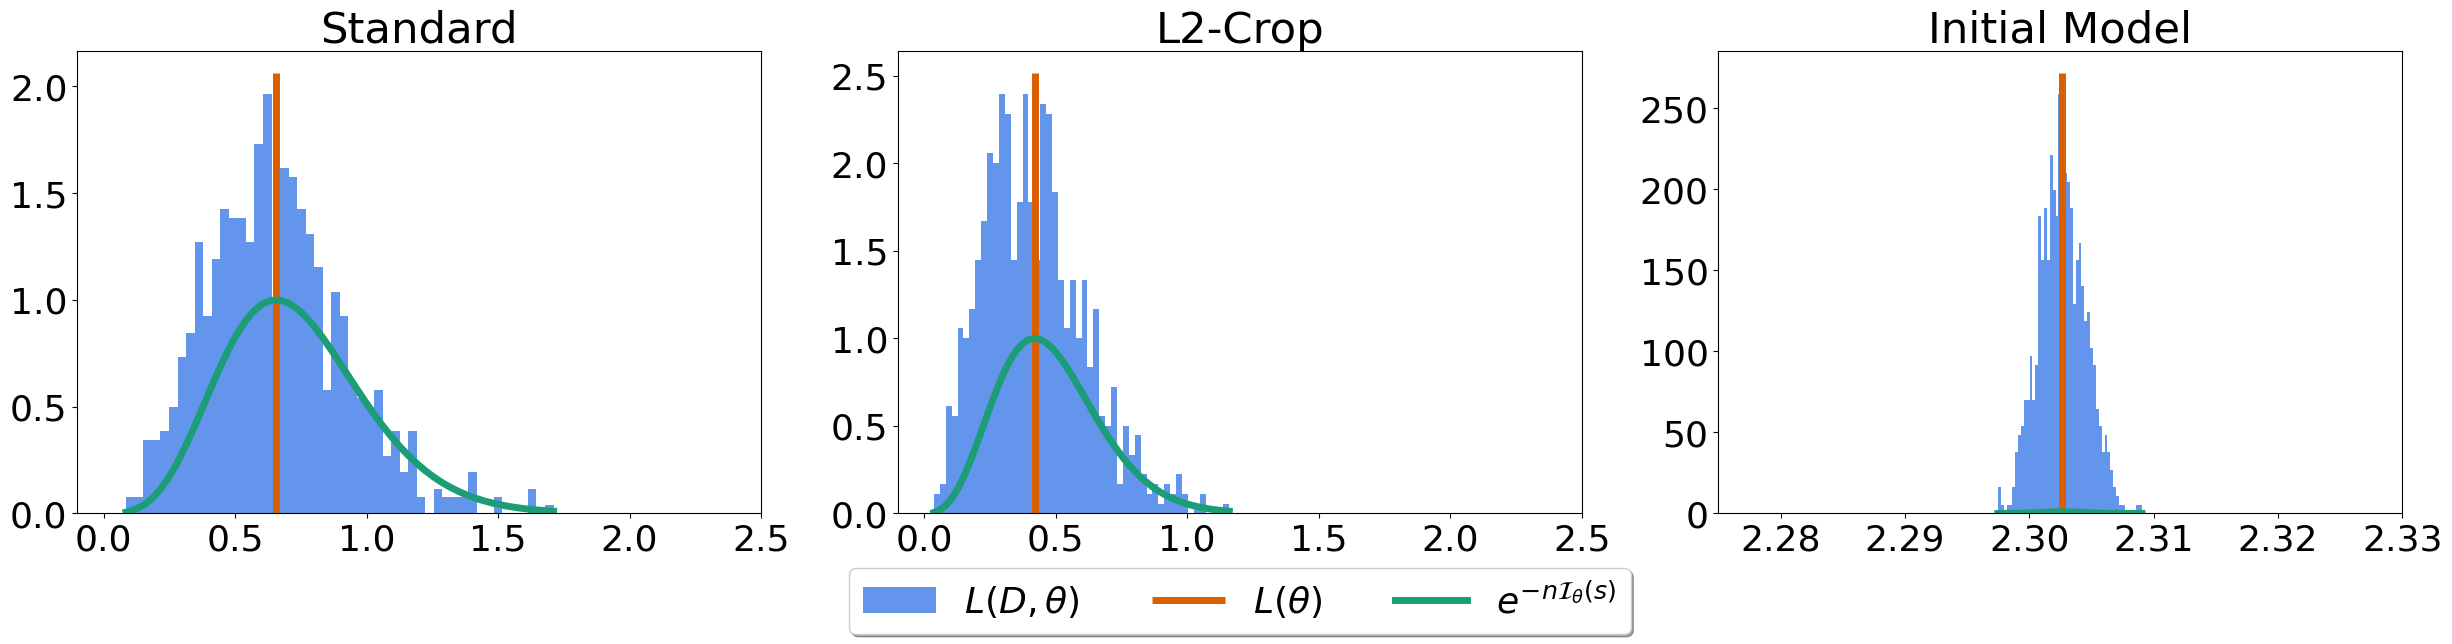

In [46]:
fig, axis = plt.subplots(1, 3)
plt.rcParams['figure.figsize'] = (30, 6)

for index, i in enumerate([0, 1, 2]):
  dif = s_values[i][1]-s_values[i][0]

  bars = axis[index].hist(np.array(train_losses)[i], bins = (test_losses[i] - s_values[i])[::-1], density = True, stacked = True, label=r"$L(D, \theta)$", color = "cornflowerblue")

  dif = s_values[i][1]-s_values[i][0]
  prop = np.sum(np.exp(-n * Is[i]))*dif
  ylims = axis[index].get_ylim()

  axis[index].vlines(test_losses[i], 0, ylims[1], label = r"$L(\theta)$", color =  cmap(1), linewidth=5)
  axis[index].plot(-s_values[i] + test_losses[i], np.exp(-n * Is[i]), label = r"$e^{-n\mathcal{I}_{\theta}(s)}$", color = cmap(-2), linewidth=5)
axis[0].set_xlim(-0.1, 2.5)
axis[1].set_xlim(-0.1, 2.5)
#axis[2].set_xlim()
axis[2].set_xlim(2.275, 2.33)
plt.legend(loc='lower center', bbox_to_anchor=(-0.7, -0.3),
          ncol=3, fancybox=True, shadow=True)
axis[0].set_title("Standard")
axis[1].set_title("L2-Crop")
axis[2].set_title("Initial Model")
plt.savefig("deviations.pdf",  bbox_inches='tight')
plt.show()

In [130]:
from matplotlib.ticker import FormatStrFormatter


def plot_separated(i, xlims, xlim2):

  fig, axis = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})


  dif = s_values[i][1]-s_values[i][0]

  bars = axis[0].hist(np.array(train_losses)[i], bins = (test_losses[i] - s_values[i])[::-1], density = True, stacked = True, label=r"$\hat{L}(D, \theta)$", color = "cornflowerblue")

  dif = s_values[i][1]-s_values[i][0]
  prop = np.sum(np.exp(-n * Is[i]))*dif
  ylims = axis[0].get_ylim()

  axis[0].vlines(test_losses[i], 0, ylims[1], label = r"$L(\theta)$", color =  cmap(1), linewidth=5)
  #axis[0].plot(-s_values[i] + test_losses[i], np.exp(-n * Is[i]), label = r"$e^{-n\mathcal{I}_{\theta}(s)}$", color = cmap(-2), linewidth=5)
  axis[0].set_xlim(xlims[0], xlims[1])


  dif = s_values[i][1]-s_values[i][0]
  bars = axis[1].hist(test_losses[i] - np.array(train_losses)[i], bins = 50, density = True, cumulative=-1,stacked = True,
                      label=r"$\mathbb{P}(L(\theta) - \hat{L}(D, \theta) \geq a)$", color = "cadetblue")
  prop = np.sum(np.exp(-n * Is[i]))*dif
  ylims = axis[0].get_ylim()

  #axis[index].vlines(test_losses[i], 0, ylims[1], label = r"$L(\theta)$", color =  cmap(1), linewidth=5)
  pos = s_values[i] > 0
  bins = axis[1].plot(np.array(s_values[i])[pos], 0.5*np.exp(-n * np.array(Is[i])[pos]),
              label = r"$e^{-n\mathcal{I}_{\theta}(a)}$", color = "goldenrod", linewidth=5)

  axis[1].set_xlim(0, xlim2)

  axis[1].yaxis.tick_right()
  #axis[0].legend(loc='lower center', bbox_to_anchor=(-0.7, -0.3),
  #          ncol=3, fancybox=True, shadow=True)
  fig.subplots_adjust(wspace=0)
  axis[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  plt.rcParams['figure.figsize'] = (10, 6)
  plt.savefig("deviations_{}.pdf".format(i),  bbox_inches='tight')
  plt.show()
  return axis



def plot_separated_crop(i, xlims, xlim2):

  fig, axis = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})


  dif = s_values_crop[i][1]-s_values_crop[i][0]

  bars = axis[0].hist(np.array(train_losses_crop)[i], bins = (test_losses_crop[i] - s_values_crop[i])[::-1], density = True, stacked = True, label=r"$\hat{L}(D, \theta)$", color = "cornflowerblue")

  prop = np.sum(np.exp(-n * Is_crop[i]))*dif
  ylims = axis[0].get_ylim()

  axis[0].vlines(test_losses_crop[i], 0, ylims[1], label = r"$L_D(\theta)$", color =  cmap(1), linewidth=5)
  axis[0].vlines(test_losses[i], 0, ylims[1], label = r"$L(\theta)$", color =  cmap(1), linewidth=5)

  #axis[0].plot(-s_values[i] + test_losses[i], np.exp(-n * Is[i]), label = r"$e^{-n\mathcal{I}_{\theta}(s)}$", color = cmap(-2), linewidth=5)
  axis[0].set_xlim(xlims[0], xlims[1])


  indexes = np.array(train_losses_crop)[i] < test_losses_crop[i]

  bars = axis[1].hist(test_losses[i] - np.array(train_losses_crop)[i][indexes], bins = 30, density = True, cumulative=-1,stacked = True,
                      label=r"$\mathbb{P}_{\nu^n|\Omega_{\bm{\theta}}}(L(\theta) - \hat{L}(D, \theta) \geq a)$", color = "cadetblue")

  prop = np.sum(np.exp(-n * Is_crop[i]))*dif
  ylims = axis[0].get_ylim()

  #axis[index].vlines(test_losses[i], 0, ylims[1], label = r"$L(\theta)$", color =  cmap(1), linewidth=5)
  pos = s_values_crop[i] > 0

  axis[1].set_xlim(0, xlim2)

  axis[1].yaxis.tick_right()
  #axis[0].legend(loc='lower center', bbox_to_anchor=(-0.7, -0.3),
  #          ncol=3, fancybox=True, shadow=True)
  fig.subplots_adjust(wspace=0)
  axis[1].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

  plt.rcParams['figure.figsize'] = (10, 6)
  plt.savefig("deviations_{}.pdf".format(i),  bbox_inches='tight')
  plt.show()
  return axis

In [131]:

latex_format()
plt.rcParams['figure.figsize'] = (10, 6)

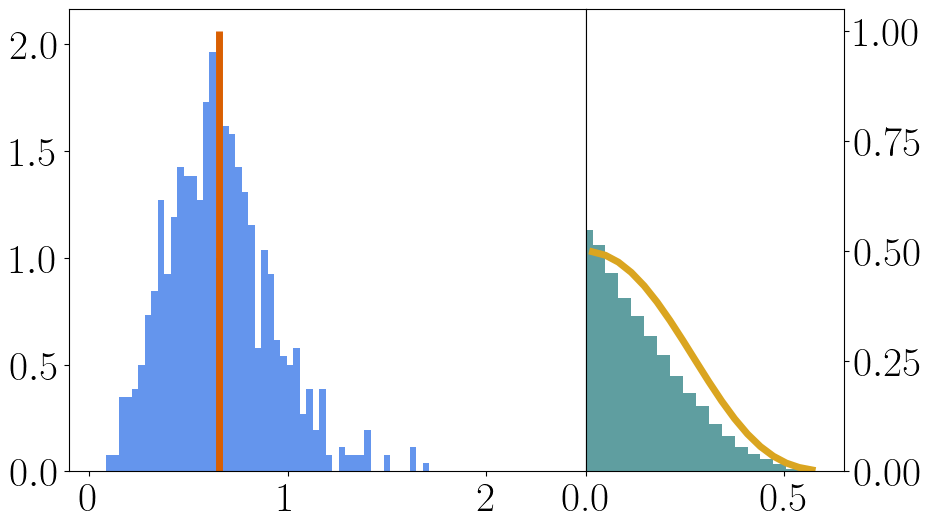

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [132]:
plot_separated(0, [-0.1, 2.5], 0.65)

In [120]:
plot_separated_crop(0, [-0.1, 2.5], 0.65)

NameError: ignored

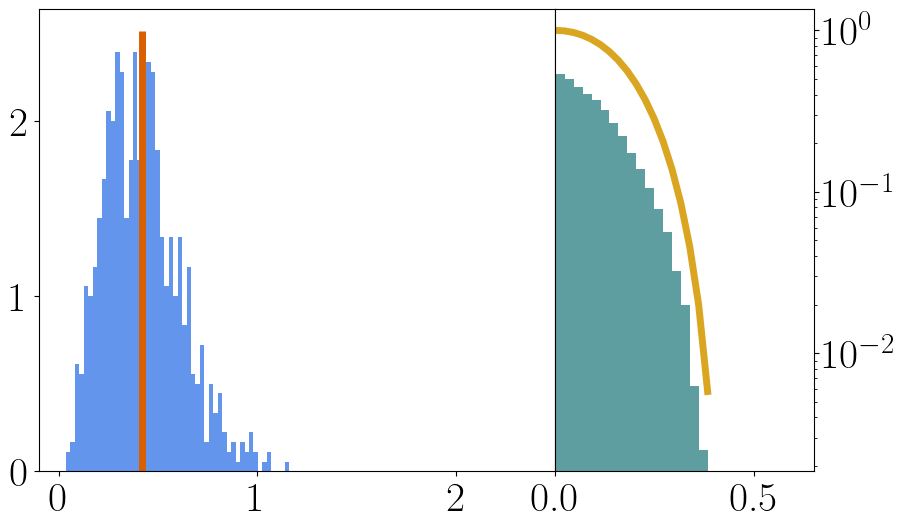

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [124]:
plot_separated(1, [-0.1, 2.5], 0.65)

In [122]:
plot_separated_crop(1, [-0.1, 2.5], 0.65)

NameError: ignored

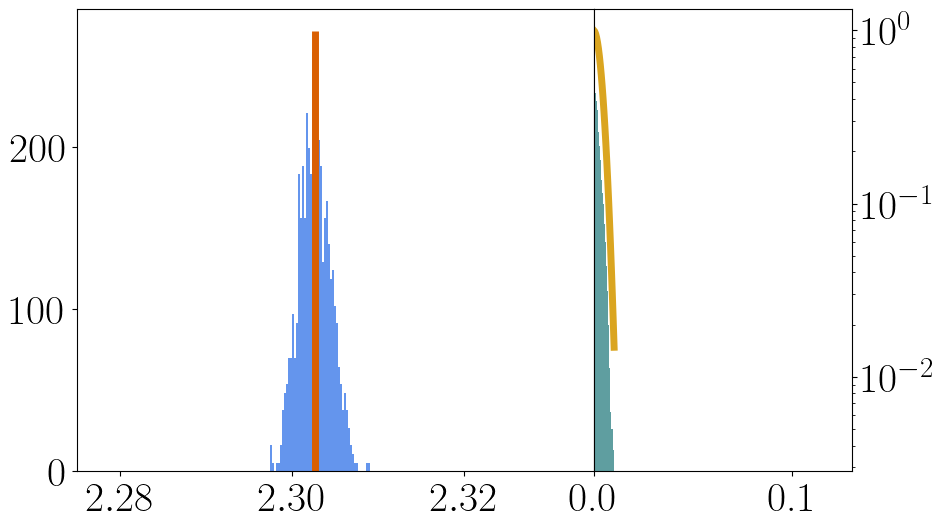

In [125]:
axis = plot_separated(2, [2.275, 2.335], 0.065)

In [94]:
axis = plot_separated_crop(2, [2.275, 2.335], 0.065)

NameError: ignored

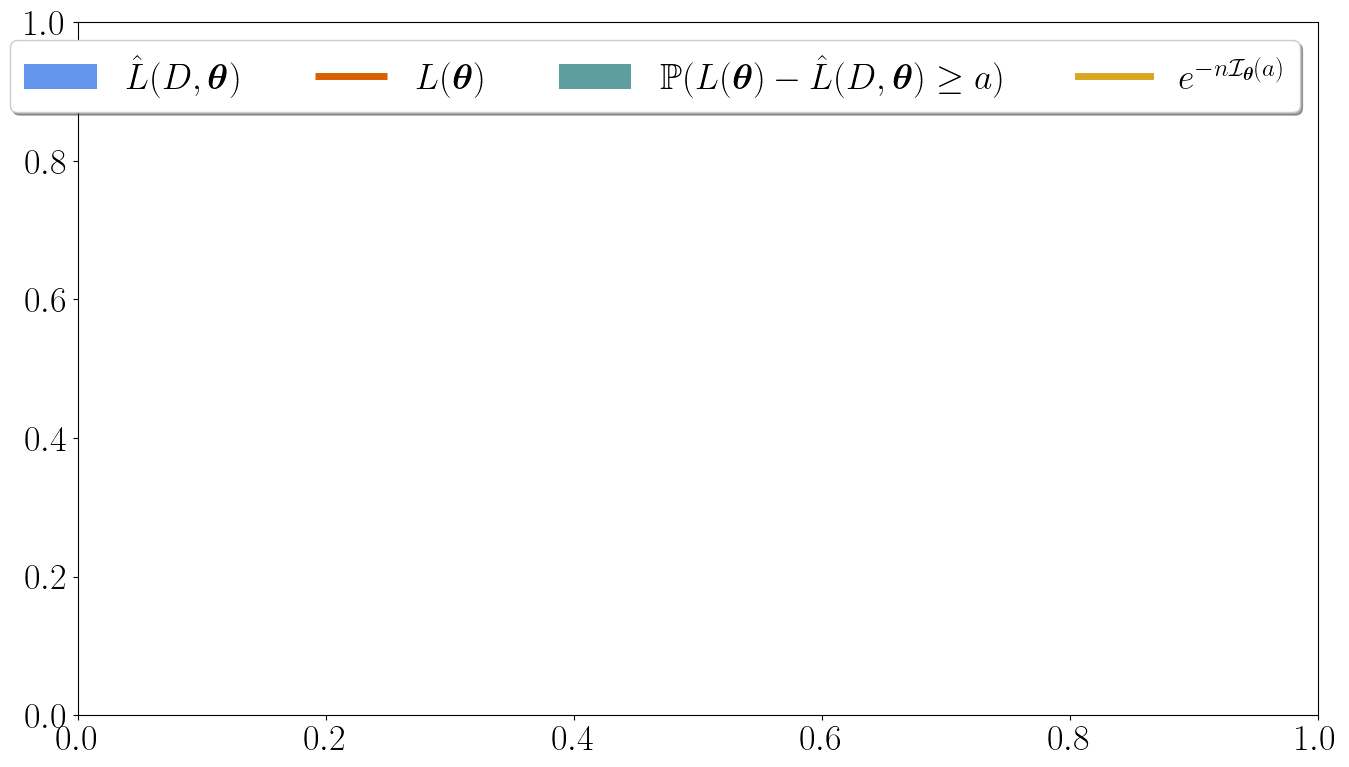

In [ ]:
# ask matplotlib for the plotted objects and their labels
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}\usepackage{bm}'
})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 26
matplotlib.rcParams.update({'font.size': fontsize})

plt.cla()
lines, labels = axis[0].get_legend_handles_labels()
lines2, labels2 = axis[1].get_legend_handles_labels()
legend = plt.legend(lines + lines2, labels + labels2, loc=0, ncol=4, fancybox=True, shadow=True)

def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

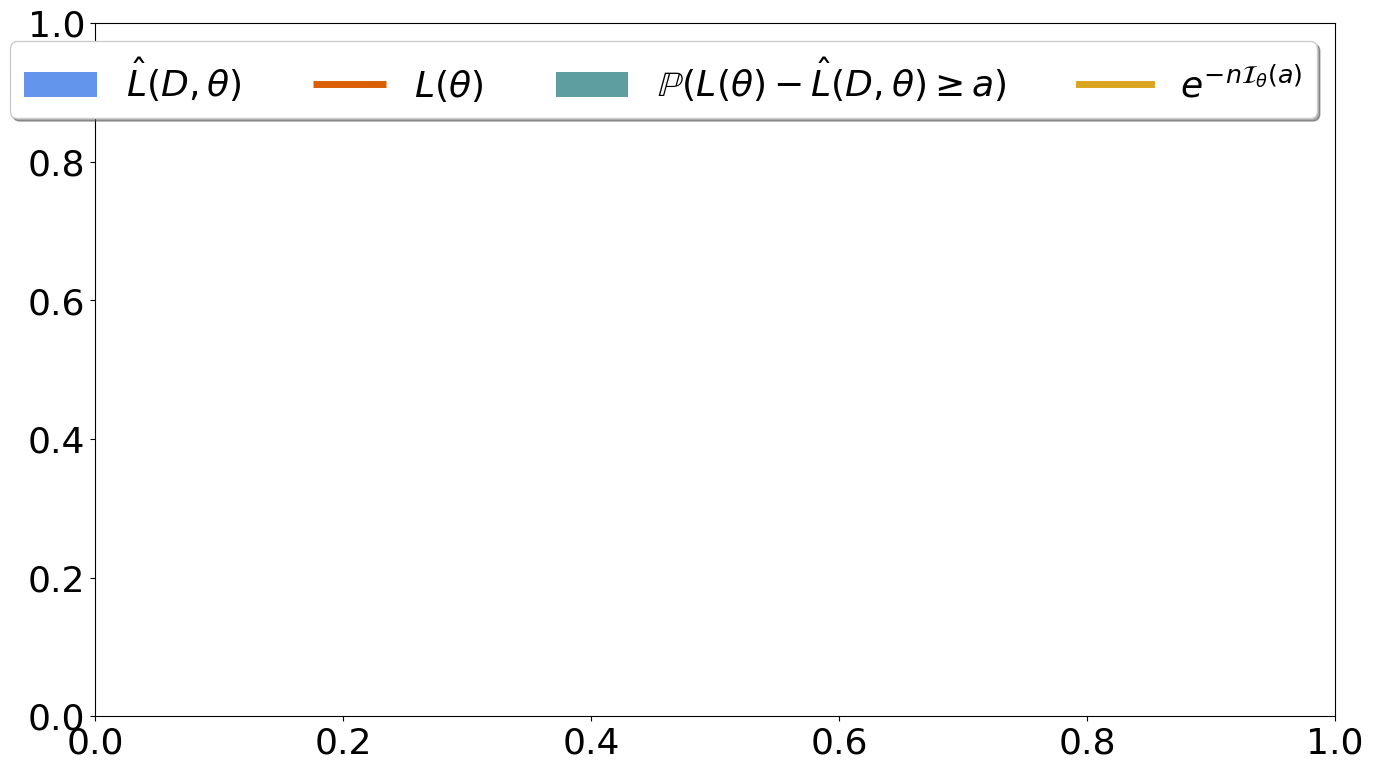

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 26
matplotlib.rcParams.update({'font.size': fontsize})

plt.cla()
lines, labels = axis[0].get_legend_handles_labels()
lines2, labels2 = axis[1].get_legend_handles_labels()
legend = plt.legend(lines + lines2, labels + labels2, loc=0, ncol=4, fancybox=True, shadow=True)

def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

# DA

In [33]:
def eval_jensen_aug(model, lambdas, mean_value):
  log_p = get_log_p(device, model, test_loader_crop_batch)
  return np.array(
      [
          (torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - lamb * mean_value).detach().cpu().numpy() for lamb in lambdas
       ])


def eval_log_p_aug(log_p, lamb, s_value, mean_value):
  jensen_val=(torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - lamb *mean_value)
  return lamb*s_value - jensen_val

def aux_rate_function_TernarySearch_aug(log_p, s_value, low, high, epsilon, mean_value):

  while (high - low) > epsilon:
    mid1 = low + (high - low) / 3
    mid2 = high - (high - low) / 3

    if eval_log_p_aug(log_p, mid1, s_value, mean_value) < eval_log_p_aug(log_p, mid2, s_value, mean_value):
        low = mid1
    else:
        high = mid2

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p_aug(log_p, mid, s_value, mean_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p_aug(log_p, mid, s_value, mean_value)).detach().cpu().numpy()]


def rate_function_BS_aug(model, s_value, mean_value, loader = test_loader_batch):
  if (s_value<0):
    min_lamb=torch.tensor(-10000).to(device)
    max_lamb=torch.tensor(0).to(device)
  else:
    min_lamb=torch.tensor(0).to(device)
    max_lamb=torch.tensor(10000).to(device)

  s_value=torch.tensor(s_value).to(device)
  log_p = get_log_p(device, model, loader)
  return aux_rate_function_TernarySearch_aug(log_p, s_value, min_lamb, max_lamb, 0.001, mean_value)

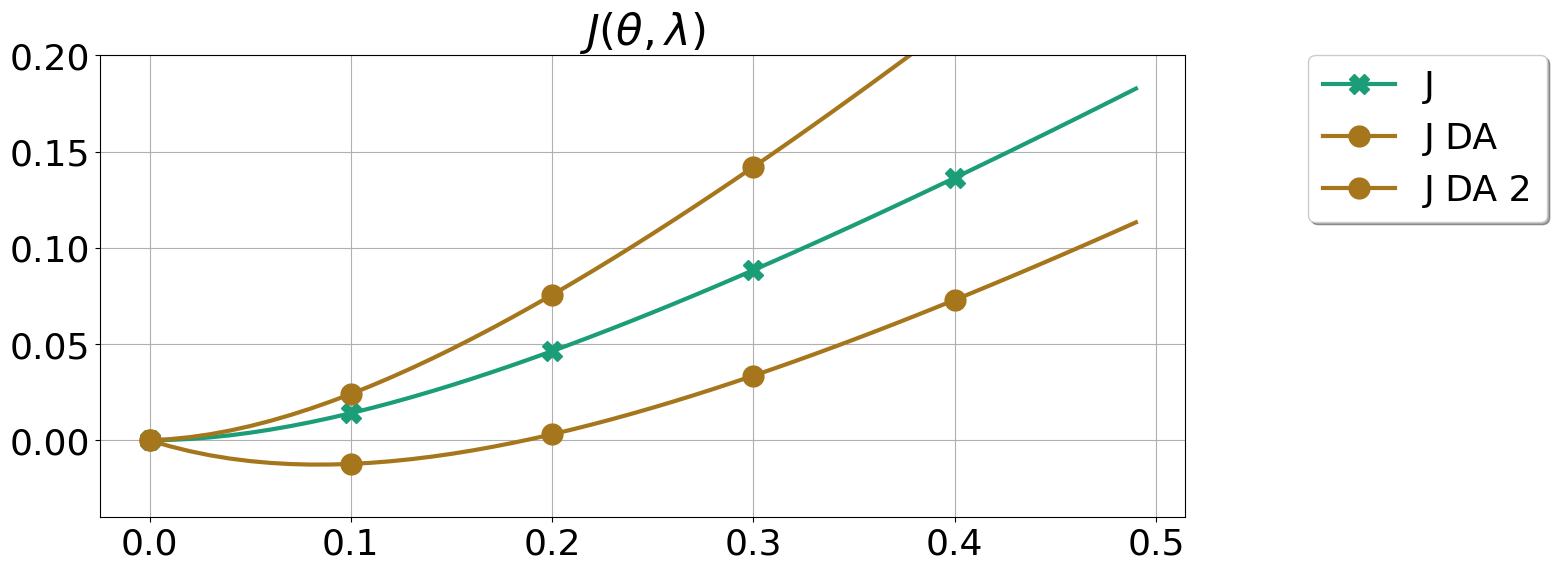

In [36]:
plt.rcParams['figure.figsize'] = (14, 6)
lambdas = np.arange(0, 0.5, 0.01)
plt.plot(lambdas, eval_jensen(results[0].to(device), lambdas), label="J" ,linewidth=3, color = colors[labels[0]], marker = markers[labels[0]],  markersize=15, markevery=10)
plt.plot(lambdas, eval_jensen_aug(results[0].to(device), lambdas, -np.mean(eval(device, results[0].to(device), test_loader_batch, criterion))), label="J DA" ,linewidth=3, color = jet(6), marker = "o",  markersize=15, markevery=10)
plt.plot(lambdas, eval_jensen_aug(results[0].to(device), lambdas, -np.mean(eval(device, results[0].to(device), test_loader_crop_batch, criterion))), label="J DA 2" ,linewidth=3, color = jet(1), marker = "o",  markersize=15, markevery=10)


plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.04),
          ncol=1, fancybox=True, shadow=True)
#plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
plt.ylim(-0.04,0.2)
plt.grid()
plt.title(r"$J(\theta,\lambda)$")

plt.savefig("sgd_images/jensen_intro.pdf", format = "pdf",bbox_inches='tight')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (14, 6)
lambdas = np.arange(0, 0.5, 0.01)
plt.plot(lambdas, eval_jensen(results[0].to(device), lambdas), label="J" ,linewidth=3, color = colors[labels[0]], marker = markers[labels[0]],  markersize=15, markevery=10)
plt.plot(lambdas, eval_jensen_aug(results[0].to(device), lambdas, 0), label="J DA" ,linewidth=3, color = jet(6), marker = "o",  markersize=15, markevery=10)
plt.plot(lambdas, eval_jensen_aug(results[0].to(device), lambdas, 0), label="J DA 2" ,linewidth=3, color = jet(1), marker = "o",  markersize=15, markevery=10)


plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.04),
          ncol=1, fancybox=True, shadow=True)
#plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
plt.ylim(-0.04,0.2)
plt.grid()
plt.title(r"$J(\theta,\lambda)$")

plt.savefig("sgd_images/jensen_intro.pdf", format = "pdf",bbox_inches='tight')
plt.show()

In [36]:
s_values = np.arange(0, 0.5, 0.01)
Is = []

for i in range(len(models)):
  Is.append(np.array([rate_function_BS(results[i].to(device), s)[0] for s in s_values]))

In [41]:
Is_crop = []
test_losses = []

for i in range(1):
  tl = np.mean(eval(device, results[i].to(device), loader, criterion))
  test_losses.append(tl)
  Is_crop.append(np.array([rate_function_BS_aug(results[i].to(device), s, -tl, test_loader_crop_batch)[0] for s in s_values]))


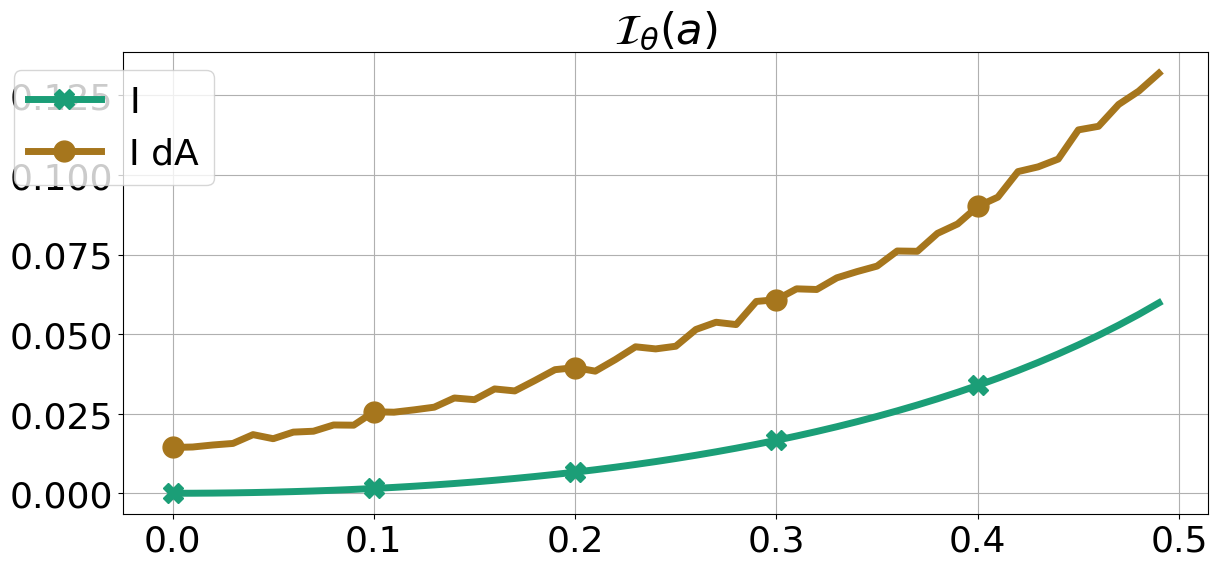

In [42]:

plt.plot(s_values, Is[0], label="I" ,linewidth=5, color = colors[labels[i]], marker = markers[labels[i]],  markersize=15, markevery=10)
plt.plot(s_values, Is_crop[0], label="I dA" ,linewidth=5, color = jet(6), marker = "o",  markersize=15, markevery=10)


#plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.04), ncol=1, fancybox=True, shadow=True)
#plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
plt.legend(fontsize=26, bbox_to_anchor=(0.1, 1))
plt.grid()
plt.title(r"${\cal I}_{\theta}(a)$")

plt.savefig("sgd_images/rate_intro_latex.pdf", format = "pdf",bbox_inches='tight')
plt.show()

# Download Files

In [ ]:
!zip sgd_images/images.zip sgd_images/*.pdf

updating: sgd_images/hist_GD.pdf (deflated 15%)
updating: sgd_images/hist_SGD-L2.pdf (deflated 16%)
updating: sgd_images/hist_SGD.pdf (deflated 16%)
updating: sgd_images/jensen_epochs.pdf (deflated 9%)
updating: sgd_images/jensen.pdf (deflated 15%)
updating: sgd_images/KL.pdf (deflated 10%)
updating: sgd_images/rates.pdf (deflated 13%)
updating: sgd_images/rates_two_axes.pdf (deflated 9%)
updating: sgd_images/sgd_inverse_rate.pdf (deflated 14%)
updating: sgd_images/sgd_train_test.pdf (deflated 13%)
updating: sgd_images/variance.pdf (deflated 14%)
updating: sgd_images/sgd_test.pdf (deflated 12%)
updating: sgd_images/sgd_train.pdf (deflated 13%)
updating: sgd_images/hist_SGD-DA.pdf (deflated 16%)
updating: sgd_images/hist_SGD-L2-DA.pdf (deflated 16%)
updating: sgd_images/jensen_intro.pdf (deflated 15%)
  adding: sgd_images/rate_intro.pdf (deflated 18%)
  adding: sgd_images/rate.pdf (deflated 18%)


In [ ]:
files.download('sgd_images/images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls -l sgd_images

total 2960424
-rw-r--r-- 1 root root      8387 Apr 26 16:50 cifar_inception_SGD-DA_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_rates_rates.pickle
-rw-r--r-- 1 root root 739410204 Apr 26 15:11 cifar_inception_SGD-DA_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_results.pickle
-rw-r--r-- 1 root root      8387 Apr 26 16:56 cifar_inception_SGD-L2-DA_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_rates_rates.pickle
-rw-r--r-- 1 root root 739411330 Apr 26 16:30 cifar_inception_SGD-L2-DA_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_results.pickle
-rw-r--r-- 1 root root      8387 Apr 26 16:44 cifar_inception_SGD-L2_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_rates_rates.pickle
-rw-r--r-- 1 root root 739411252 Apr 26 13:53 cifar_inception_SGD-L2_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_results.pickle
-rw-r--r-- 1 root ro